In [1]:
# TODO

In [9]:
!pip install transformers==4.5.0 fugashi==1.1.0 ipadic==1.0.0
!pip install datasets

     |████████████████████████████████| 2.1 MB 11.9 MB/s 
     |████████████████████████████████| 486 kB 48.8 MB/s 
     |████████████████████████████████| 13.4 MB 36.1 MB/s 
     |████████████████████████████████| 3.3 MB 42.5 MB/s 
     |████████████████████████████████| 895 kB 40.3 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=76776b622cf12abfaa8bf755cde1bc87633f62206477f9e21500b4bdb51a90ed
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic
     |████████████████████████████████| 325 kB 12.1 MB/s 
     |████████████████████████████████| 212 kB 49.3 MB/s 
     |████████████████████████████████| 1.1 MB 45.7 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 134 kB 50.9 MB/s 
     |████████████████████████████████| 127 kB 32.2 MB/s 
     |████████████████████████████████| 144 kB 52.3 MB/s 
     |█████████████

In [10]:
# ライブラリ
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertJapaneseTokenizer, BertModel
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
# パラメータ
MAX_LENGTH = 32
#NEGA_SIZE = 1
NUM_EPOCHS = 10
#BATCH_SIZE = 1
LEARNING_RATE = 0.0001
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

drive.mount("/content/drive/")
INPUT_PATH = "/content/drive/My Drive/NLP/work/10_my_task/01_bert_sentence_cls/input/" 
OUTPUT_PATH = "/content/drive/My Drive/NLP/work/10_my_task/01_bert_sentence_cls/output/model/" 
LOSS_PATH = "/content/drive/My Drive/NLP/work/10_my_task/01_bert_sentence_cls/output/loss/" 

cuda
Mounted at /content/drive/


In [12]:
# モジュール
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME) 
model = BertModel.from_pretrained(MODEL_NAME).to(device)

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [13]:
# 重み初期値を固定
torch.manual_seed(12345)
torch.cuda.manual_seed(12345)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [14]:
# データ
df = pd.read_csv(INPUT_PATH + "sample_4.csv", encoding='shift-jis')
df_train = df[df['Train']==1].copy().reset_index(drop=True) # dataloaderに入れるためにindexの初期化必須
df_valid = df[df['Train']==0].copy().reset_index(drop=True) # dataloaderに入れるためにindexの初期化必須
print(df.shape, df_train.shape, df_valid.shape)
df.head(3)
df_train.head(3)

(40, 4) (20, 4) (20, 4)


,Q,T,Template,Train
0,振込限度額を教えてください。,振込限度額は100万円です。,1,1
1,振込の限度額はいくらですか。,振込限度額は100万円です。,1,1
2,口座開設したいです。,口座開設方法はこちらになります。,2,1


In [15]:
# カスタマイズデータセット
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, df, max_length, nega_size=1):
    self.q = df['Q']
    self.t = df['T']
    self.qa = df['Q'] + '[SEP]' + df['T']
    self.max_length = max_length
    self.nega_size = nega_size

  def __len__(self):
    return len(self.q)

  # トークナイズ処理
  def tokenize(self, batch):
    encoding = tokenizer(batch, padding='max_length', truncation=True, max_length=self.max_length) # , return_tensors='pt'
    encoding = {k: torch.tensor(v) for k, v in encoding.items()}
    return encoding

  # トークナイズ対象レコードの選択
  def get_negalist_by_random(self, template, nega_size):
    cdt_nega = self.qa[self.t!=template] 
    negatives = cdt_nega.sample(n=nega_size).iloc[0]
    return negatives
    
  # トークナイズ対象レコードの選択
  def get_negalist_by_cossim(self, template, nega_size):
    cdt_nega = self.qa[self.t!=template] 
    # cdt_nega_idx = cdt_nega.index # TODO
    negatives = cdt_nega.sample(n=nega_size)
    return [self.tokenize(negative) for negative in negatives]

  # miniバッチ用データの切り出し(トークナイズ対象レコードの選択->トークナイズ処理->エンコード結果返却)
  def __getitem__(self, idx):
    anchor = self.tokenize(self.q[idx])
    positive = self.tokenize(self.qa[idx])
    negative = self.tokenize(self.get_negalist_by_random(self.t[idx], self.nega_size))
    return {'anchor':anchor, 'positive':positive, 'negative': negative} 

In [16]:
# # 確認
# ds = CustomDataset(df_train, MAX_LENGTH)
# dl = DataLoader(ds, batch_size=4, shuffle=False)
# print(len(ds))
# print(len(dl))
# #print(ds[1])
# print(iter(dl).next())
# # print(iter(dl).next()['anchor'])
# # print(iter(dl).next()['anchor']['input_ids']) 
# # print(iter(dl).next()['anchor']['input_ids'][1]) 
# # print(iter(dl).next()['negative']['input_ids'][0]) 

In [17]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.00001
model = BertModel.from_pretrained(MODEL_NAME).to(device)

In [18]:
# モデル学習パラメータ
criterion = nn.TripletMarginLoss(margin=1.0, p=2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# # 学習対象パラメータ設定
# for num_layers in range(model.config.num_hidden_layers-1):
#   for param in model.encoder.layer[num_layers].parameters():
#     param.requires_grad = False

In [19]:
# # 確認
# ds = CustomDataset(df_valid, MAX_LENGTH)
# dl = DataLoader(ds, batch_size=2, shuffle=False)
# for step, batch in enumerate(dl):
#   print(step)
#   #break
# #print(batch)
# #anchor_input_ids = batch['anchor']['input_ids'].to(device) 
# #print(anchor_input_ids)

In [20]:
min_loss = 100000
train_loss = []
valid_loss = []

# epoch毎にデータ作成
dl_train = DataLoader(CustomDataset(df_train, MAX_LENGTH), batch_size = 4, shuffle=True) # TODO:df->train, valid
dl_valid = DataLoader(CustomDataset(df_valid, MAX_LENGTH), batch_size = 4, shuffle=False) # TODO:df->train, valid
data_loader = {'train': dl_train, 'valid': dl_valid}

for epoch in range(NUM_EPOCHS):

  # epoch毎に学習と検証のループ
  for phase in ['train', 'valid']:
    epoch_loss = 0.0
    if phase=='train':
      model.train()
    else:
      model.eval()

    # epoch毎×学習検証毎にバッチのループ
    for step, batch in enumerate(data_loader[phase]):

      anchor_input_ids = batch['anchor']['input_ids'].to(device) 
      positive_input_ids = batch['positive']['input_ids'].to(device)
      negative_input_ids = batch['negative']['input_ids'].to(device)

      anchor_attention_mask = batch['anchor']['attention_mask'].to(device)
      positive_attention_mask = batch['positive']['attention_mask'].to(device)
      negative_attention_mask = batch['negative']['attention_mask'].to(device)

      optimizer.zero_grad()
      with torch.set_grad_enabled(phase=='train'):
        # [CLS]トークンのベクトル
        lhs_anchor = model(anchor_input_ids, anchor_attention_mask, return_dict=True).last_hidden_state[:,0,:] # batch, sentence, feature->1(文章),768(特徴量)
        lhs_posi = model(positive_input_ids, positive_attention_mask, return_dict=True).last_hidden_state[:,0,:]
        lhs_nega = model(negative_input_ids, negative_attention_mask, return_dict=True).last_hidden_state[:,0,:]
        #print(lhs_anchor.shape, lhs_posi.shape, lhs_nega.shape)

        loss = criterion(lhs_anchor, lhs_posi, lhs_nega)
        epoch_loss += loss.item()

        if phase=='train':
          loss.backward()
          optimizer.step()
        # メモリ解放(TODO?)

    # epoch毎×学習検証毎にログ
    if phase=='train':
      train_loss.append(epoch_loss/len(df_train)) # TODO:train, valid
    else:
      valid_loss.append(epoch_loss/len(df_valid)) # TODO:train, valid
      print('epoch:{0}  train_loss:{1:.4f}, valid_loss:{2:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))
      if epoch_loss < min_loss:
        min_loss = epoch_loss
        #torch.save(model.state_dict(), OUTPUT_PATH + f"model_epoch_{epoch}.pth")

epoch:0  train_loss:0.0428, valid_loss:0.0090
epoch:1  train_loss:0.0000, valid_loss:0.0018
epoch:2  train_loss:0.0019, valid_loss:0.0182
epoch:3  train_loss:0.0153, valid_loss:0.0000
epoch:4  train_loss:0.0200, valid_loss:0.0000
epoch:5  train_loss:0.0153, valid_loss:0.0000
epoch:6  train_loss:0.0000, valid_loss:0.0000
epoch:7  train_loss:0.0000, valid_loss:0.0000
epoch:8  train_loss:0.0125, valid_loss:0.0000
epoch:9  train_loss:0.0000, valid_loss:0.0000
epoch:10  train_loss:0.0023, valid_loss:0.0000
epoch:11  train_loss:0.0000, valid_loss:0.0000
epoch:12  train_loss:0.0000, valid_loss:0.0000
epoch:13  train_loss:0.0000, valid_loss:0.0000
epoch:14  train_loss:0.0000, valid_loss:0.0000
epoch:15  train_loss:0.0000, valid_loss:0.0000
epoch:16  train_loss:0.0000, valid_loss:0.0000
epoch:17  train_loss:0.0000, valid_loss:0.0000
epoch:18  train_loss:0.0000, valid_loss:0.0000
epoch:19  train_loss:0.0000, valid_loss:0.0000


In [21]:
# lossの出力
pd.Series(train_loss).to_csv(LOSS_PATH + "train_loss.csv", index=False)
pd.Series(valid_loss).to_csv(LOSS_PATH + "valid_loss.csv", index=False)

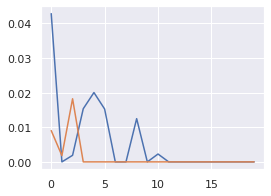

In [22]:
# lossの可視化
# 可視化
plt.figure(figsize=(4,3))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.show()

In [23]:
# modelの出力
model.save_pretrained(OUTPUT_PATH + 'last.bin')

In [34]:
# # カスタマイズデータセット
# class CustomDataset(torch.utils.data.Dataset):

#   def __init__(self, df, max_length, nega_size):
#     print(df.shape)
#     self.q = df['Q']
#     self.t = df['T']
#     self.qa = df['Q'] + '[SEP]' + df['T']
#     self.max_length = max_length
#     self.nega_size = nega_size

#   def __len__(self):
#     return len(self.q)

#   # トークナイズ処理
#   def tokenize(self, batch):
#     encoding = tokenizer(batch, padding='max_length', truncation=True, max_length=self.max_length) # , return_tensors='pt'
#     encoding = {k: torch.tensor(v) for k, v in encoding.items()}
#     return encoding

#   # トークナイズ対象レコードの選択
#   def get_negalist_by_random(self, template, nega_size):
#     cdt_nega = self.qa[self.t!=template] 
#     negatives = cdt_nega.sample(n=nega_size)
#     return negatives
    
#   # トークナイズ対象レコードの選択
#   def get_negalist_by_cossim(self, template, nega_size):
#     cdt_nega = self.qa[self.t!=template] 
#     # cdt_nega_idx = cdt_nega.index # TODO
#     negatives = cdt_nega.sample(n=nega_size)
#     return [self.tokenize(negative) for negative in negatives]

#   # miniバッチ用データの切り出し(トークナイズ対象レコードの選択->トークナイズ処理->エンコード結果返却)
#   def __getitem__(self, idx):
#     anchor = self.tokenize([self.q[idx] for _ in range(self.nega_size)]) # 効率化可能
#     positive = self.tokenize([self.qa[idx] for _ in range(self.nega_size)])
#     negative = self.tokenize(list(self.get_negalist_by_random(self.t[idx], self.nega_size).values))
#     return {'anchor':anchor, 'positive':positive, 'negative': negative} 